In [123]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import ShortTimeFFT, windows
import librosa
import torch

In [124]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Clasificador con LSTMs
Vamos a hacer un clasificador con LSTMs utilizando un espectrograma. 

## Lectura de datos y creación de los espectrogramas

In [125]:
# vemos los archivos de audio 
data_folder = os.path.join('..','codigo', 'data', 'train')  # carpeta del training set
classes_folders = os.listdir(data_folder)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data = {}
for c in classes_folders:
    if c[0] != '.':
        data[c] = data.get(c, []) # agregamos 

# Llenamos una lista para cada clase con los datos
for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=None)  # leemos el audio como numpy array
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

La clase colectivo tiene 5 elementos
La clase moto tiene 3 elementos
La clase auto tiene 3 elementos


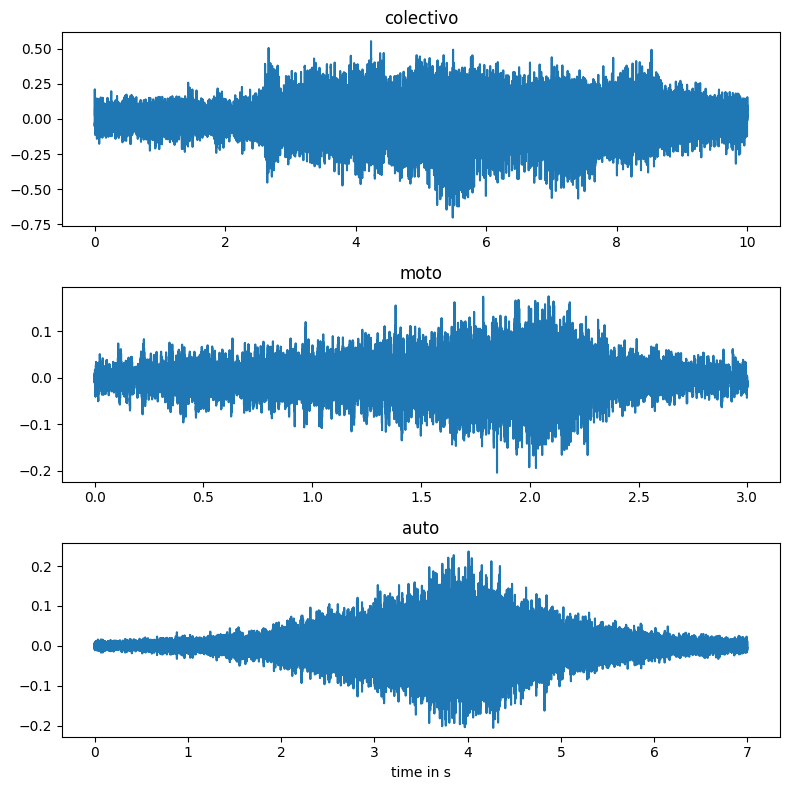

In [126]:
# dibujamos algun datito
rng = np.random.default_rng()
sr = 22050
keys = list(data.keys())
fig, axs = plt.subplots(3,1, figsize = (8,8))
for i in range(3):
    idx = rng.integers(len(data[keys[i]]))
    signal = data[keys[i]][idx]
    axs[i].set_title(keys[i])
    axs[i].plot(np.arange(len(signal))/sr, signal)
axs[i].set_xlabel(f'time in s')
fig.tight_layout()

In [181]:
def create_specs(x, ws, sr):
    '''Wrapper para calcular los espectrogramas de manera sencilla
    Regresa las frecuencias, los intervalos de tiempo y el espectrograma normalizado entre 0 y 1'''
    N = len(x)
    SFT = ShortTimeFFT(windows.boxcar(400), hop=400, fs=sr, scale_to='magnitude')
    ts = SFT.delta_t * np.arange(N)/ws
    Sx = SFT.spectrogram(x)  # perform the STFT
    Sx_l = np.log(Sx[:])
    Sx = (Sx_l - Sx_l.min())
    Sx /= Sx.max()
    
    return SFT.f, ts[::ws], Sx

In [182]:
# para hacer un entrenamiento vamos a utilizar como features los espectrogramas
ws = 220  # Ancho de la ventana temporal
spects = {}         # creamos listas vacías
for k in data.keys():
    spects[k] = spects.get(k, [])

# llenamos las listas con espectrogramas
for k in data.keys():
    for d in data[k]:
        spec = create_specs(d, ws=400, sr = 22050)
        spects[k].append(spec)


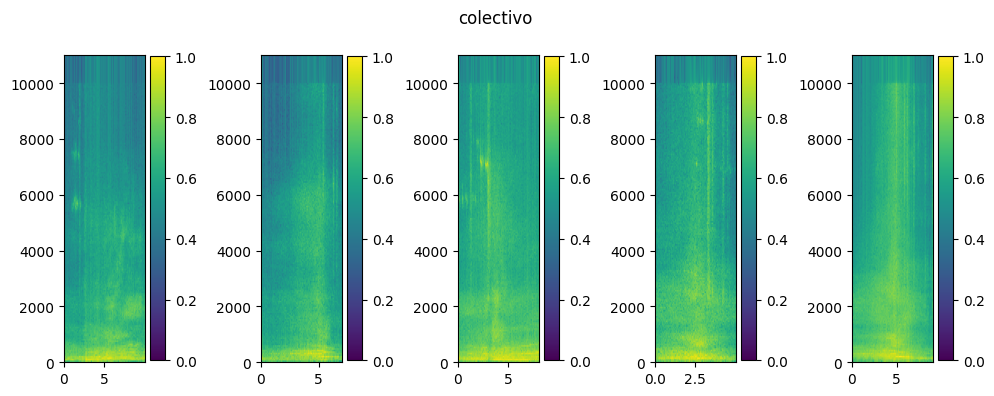

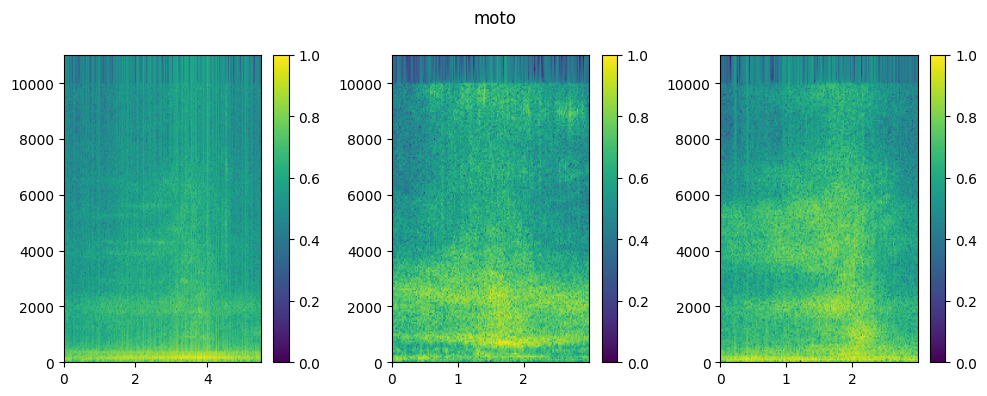

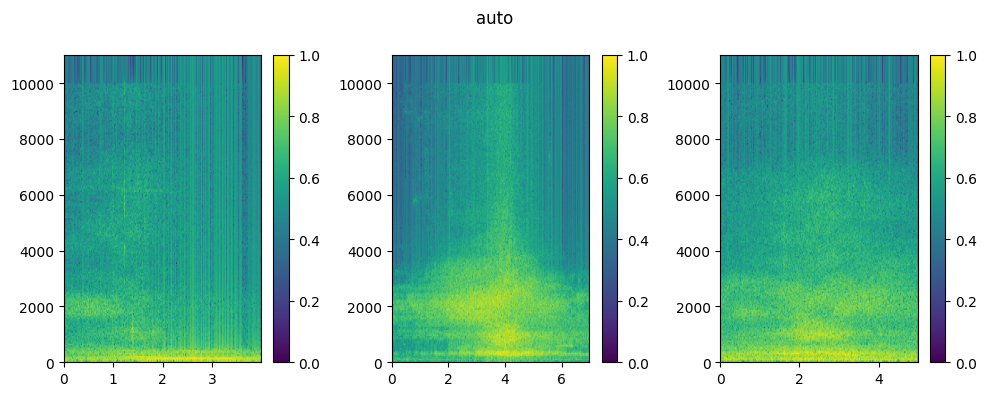

In [183]:
for k in spects.keys():
    i=0
    plt.figure(figsize=(10,4))
    for s in spects[k]:
        i += 1
        plt.subplot(1, len(spects[k]), i)
        plt.imshow(s[2], origin='lower', extent=[s[1][0],s[1][-1],s[0][0], s[0][-1]], aspect='auto', interpolation=None)
        plt.colorbar()
    plt.suptitle(k)
    plt.tight_layout()
    plt.show()

In [184]:
print(spects['colectivo'][0][0])

[    0.       55.125   110.25    165.375   220.5     275.625   330.75
   385.875   441.      496.125   551.25    606.375   661.5     716.625
   771.75    826.875   882.      937.125   992.25   1047.375  1102.5
  1157.625  1212.75   1267.875  1323.     1378.125  1433.25   1488.375
  1543.5    1598.625  1653.75   1708.875  1764.     1819.125  1874.25
  1929.375  1984.5    2039.625  2094.75   2149.875  2205.     2260.125
  2315.25   2370.375  2425.5    2480.625  2535.75   2590.875  2646.
  2701.125  2756.25   2811.375  2866.5    2921.625  2976.75   3031.875
  3087.     3142.125  3197.25   3252.375  3307.5    3362.625  3417.75
  3472.875  3528.     3583.125  3638.25   3693.375  3748.5    3803.625
  3858.75   3913.875  3969.     4024.125  4079.25   4134.375  4189.5
  4244.625  4299.75   4354.875  4410.     4465.125  4520.25   4575.375
  4630.5    4685.625  4740.75   4795.875  4851.     4906.125  4961.25
  5016.375  5071.5    5126.625  5181.75   5236.875  5292.     5347.125
  5402.25   5457.

## Creación del modelo de LSTM

Este modelo recibe como input un espectro de 201 frecuencias (porque usamos una ventana de 400 datos). A su vez, dada la forma en que se realiza la FFT, tendremos sampleadas estas frecuencias de manera equiespaciadas cada unos 55 Hz (aproximadamente), desde 0 hasta 11025 Hz. Supondremos que esta discretización en frecuencias es adecuada. 

Como tenemos series de datos sin un largo fijo, lo más adecuado es utilizar RNNs. Por otra parte esto nos permitirá pasar tramos de la serie para un aprendizaje más eficiente, incrementando el conjunto de entrenamiento

Además debemos codificar los tipos de clases, lo haremos con el tipo _One-Hot encoding_

In [185]:
from sklearn.preprocessing import LabelEncoder

In [186]:
# poniendo todos los datos como una lista
train_x = []
labels = []
for k in spects.keys():
    for s in spects[k]:
        train_x.append(s[2])
        labels.append([k])

In [187]:
# Creamos el encoder
enc = LabelEncoder()
# transformamos y tenemos nuestros ground truth
train_y = enc.fit_transform(labels).reshape(-1,1)

/home/sebastian/Documents/Codes/Traffic-Maxi/MAXIABDALA/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [188]:
print(train_y)

[[1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]]


In [214]:
class SimpleLSTM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size  = 201,
                                  hidden_size = 64,
                                  num_layers  = 5,
                                  batch_first = True,
                                  bidirectional= True)
        self.fcon = torch.nn.Linear( in_features  = 2* 64,
                                     out_features = 3)

    def forward(self, x):

        x, _ = self.lstm(x)
        x = self.fcon(x)
        # x = torch.sigmoid(x)
        return x[:,-1,:].squeeze(1) # regresamos el ultimo valor (many to one)

In [215]:
model = SimpleLSTM().to(device)
# vamos a probar el modelo (pasamos los n primeros conjuntos de frecuencias del espectrograma)
n = 5
print(f'Shape del tensor de entrada: {torch.from_numpy(train_x[0][:,:n].reshape(1,n,201)).float().shape}')
print(f'tensor de salida: {model(torch.from_numpy(train_x[0][:,:n].reshape(1,n,201)).float().to(device))}')

Shape del tensor de entrada: torch.Size([1, 5, 201])
tensor de salida: tensor([[0.0463, 0.0612, 0.0244]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [216]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()
hist = []

4.483164831995964
4.124033077387139
3.7859867580700666
3.427255322225392
3.088562714634463
2.8284548516385257
2.6705798266921192
2.5835579729173332
2.5228601126000285
2.468475532485172
2.4797851846087724
1.616448060842231
0.8941492037847638
0.61248381389305
0.5743052265606821
0.9749298235401511
5.614804929122329
4.203689789865166
7.284214909304865
0.9981998326256871
3.4728887639939785
1.505992205813527
0.5320562263950706
0.515652650501579
0.4239252828992903
0.3621945851482451
0.31980674946680665
0.288489340338856
0.2638529483228922
0.24359500664286315
0.22639087145216763
0.21147829806432128
0.19832072057761252
0.1865516803227365
0.17587886820547283
0.16614340152591467
0.1572951772250235
0.14928437024354935
0.1420551820192486
0.13551990152336657
0.12956633989233524
0.12411274726036936
0.11908989457879215
0.11443865101318806
0.11010838486254215
0.10606998589355499
0.10229336970951408
0.09875034529250115
0.09543099615257233
0.09230327047407627
0.08935591240879148
0.08656687464099377
0.083

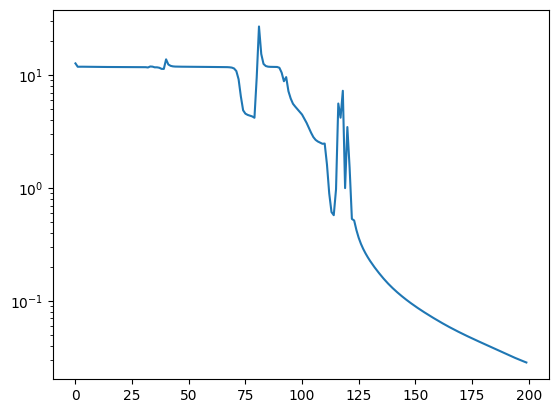

In [239]:
for e in range(100):
    cum = 0
    for i in range(len(train_x)):
        n_samples = train_x[i].shape[1]
        n_features = train_x[i].shape[0]
        x = torch.FloatTensor(train_x[i][:n_features,:]).view(1,n_samples, n_features).to(device)
        y = torch.LongTensor(train_y[i]).to(device)
        y_pred = model(x)
        print(x.shape, y.shape, y_pred.shape)
        loss = criterion( y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cum += loss.item()
    print(cum)
    hist.append(cum)
plt.semilogy(hist)

In [248]:

idx = np.random.randint(10)
print(train_x[idx].shape)
pp = model(torch.from_numpy(train_x[idx].reshape(1,-1,201)).float().to(device)).detach().cpu().numpy()
print('pred',enc.inverse_transform(np.argmax(pp).reshape(1)))
print('true',enc.inverse_transform(train_y[idx].reshape(1)))


(201, 387)
pred ['colectivo']
true ['colectivo']
